# Sentiment Analysis

This is my first project regarding NLP. The goal with this project is to learn how to perform Sentiment Analysis from scratch, and for that reason I will try to use as fewer libraries as possible.

The dataset that I will be using is the following from Kaggle: https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset/data





In [130]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers

# let pandas write the whole sentence
pd.set_option('display.max_colwidth', 1000)


In [131]:
# load the dataset

filename = "/kaggle/input/spotify-dataset/DATASET.csv"
df = pd.read_csv(filename)
print(df.shape)
df.head(10)

(52702, 2)


,Review,label
0,"Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.",POSITIVE
1,Please ignore previous negative rating. This app is super great. I give it five stars+,POSITIVE
2,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get rid of this.",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?,NEGATIVE
5,The player controls sometimes disappear for no reason. App restart forgets what I was playing but fixes the issue.,NEGATIVE
6,I love the selection and the lyrics are provided with the song you're listening to!,POSITIVE
7,"Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done NOTHING to solve it! Over time I have changed sd cards, each being faster in read, write speeds(all samsung brand). And please add ""don't like song"" so it will never appear again in my searches or playlists.",NEGATIVE
8,"It's a great app and the best mp3 music app I have ever used but there is one problem that, why can't we play some songs or find some songs? despite this the app is wonderful I recommend it. it's just the best.",POSITIVE
9,"I'm deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consumer doesn't want to pay for music they can't fully own, and 6 ads successively, upon logging in, before a single song, is too much. Closed the app during ad number 6, and I'm more patient than most. If those are the only ways you can profit: you've already peaked. All that's left is your decline.",NEGATIVE


## Preprocessing

After loading the dataset, we should do some preprocessing. The first thing that we are going to do is some general EDA and then proceed to process the text.

### EDA




In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52702 entries, 0 to 52701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  52686 non-null  object
 1   label   52702 non-null  object
dtypes: object(2)
memory usage: 823.6+ KB


Lets check for missing and duplicated values

In [133]:
print("Null:")
df.isnull().sum()


Null:


Review    16
label      0
dtype: int64

In [134]:
print("Duplicate:")
df.duplicated().sum()

Duplicate:


1229

We can see that there are 16 null entries, but also 1229 duplicated ones. We are going to drop them.

In [135]:
df = df.dropna()
df = df.drop_duplicates()

Lets check with a plot how the classes are distributed:

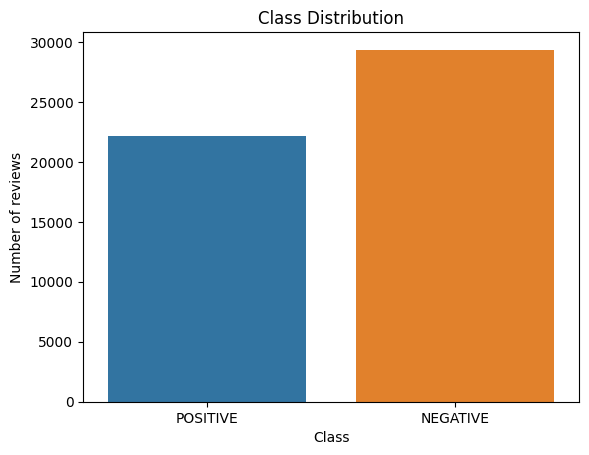

In [136]:
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xlabel("Class")
plt.ylabel("Number of reviews")
plt.show()

We can see a higher number of negative reviews, but nonetheless, the difference is not drastic.

After this, we can start preprocessing the text. Although there exists libraries that could do this for us such as `NLTK` or `TextBlob`, I'm going to do it manually.

We are going to perform the following:

- Clean the text
- Tokenize
- Remove stopwords
- Lemmatization/Stemming

### Clean the text

The process is going to be like this:
1. Convert slangs like ASAP into As Soon As Possible
2. Turn everything to lowercase
3. Remove punctuations, html tags, accents and so on, if it was in another language like spanish i would convert the accents into their non-accent version, e.g. á would be a, but since it is in english I will delete them.

In [137]:
# source: https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt

abbreviations = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My Ass Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My Ass Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The Fuck",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don’t care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can’t stop laughing"
}

def replace_abbreviation(text):
    # if the abbreviation is not found, the word is added as is
    result = [abbreviations.get(word.upper(), word) for word in text.split()]
    # join the list
    return " ".join(result)

example = "AFAIK Spotify is an app, CU"
print("Example:\n" + example)
print("Result:\n" + replace_abbreviation(example))

df['Review'] = df['Review'].apply(lambda x: replace_abbreviation(x))

            

Example:
AFAIK Spotify is an app, CU
Result:
As Far As I Know Spotify is an app, See You


In [138]:
# lowercase
print("Before:\n" + df.iloc[0]['Review'])
df['Review'] = df['Review'].apply(lambda x: x.lower())
print("After:\n" + df.iloc[0]['Review'])

Before:
Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.
After:
great music service, the audio is high quality and the app is easy to use. also very quick and friendly support.


In [139]:
# remove punctuations, brackets, <html>, etc.
print("Chars to remove: " + string.punctuation)

def remove_punctuation(sentence):
    # make a list with the chars that are not punctuation
    no_punct = [char for char in sentence if char not in string.punctuation]
    # print(no_punct)
    # join the list into a string
    no_punct = ''.join(no_punct)
    return no_punct
            
print("\nBefore:\n" + df.iloc[1]['Review'])
df['Review'] = df['Review'].apply(lambda x: remove_punctuation(x))
print("\nAfter:\n" + df.iloc[1]['Review'])

Chars to remove: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

Before:
please ignore previous negative rating. this app is super great. i give it five stars+

After:
please ignore previous negative rating this app is super great i give it five stars


This next cell could replace the previous one since what im going to do is to replace all characters that are not a-z, number or a space with a blank, so it would also get rid of punctuation, but just for the sake of showing 2 alternatives I'll do it again. Also I will look if there is cases with more than one blank space and remove them.

In [140]:
# remove special characters, like accents


def clean_text(sentence):
    pattern = r"[^a-z0-9\s]"
    clean = re.sub(pattern, "", sentence)
    spaces_pattern = r"\s+"
    return re.sub(spaces_pattern, " ", clean)

sentence = "exampl3 of a     sentence!,,,"

print("Before:\n" + sentence)
print("After:\n" + clean_text(sentence))

df['Review'] = df['Review'].apply(lambda x: clean_text(x))

Before:
exampl3 of a     sentence!,,,
After:
exampl3 of a sentence


### Tokenization

Since we have already removed everything but the letters and numbers and made sure that each word is separated with just one blank space, we can make use of the `.split()` method in python to tokenize the string without needing any other library

In [141]:
def tokenize_text(text):
    return text.split()

print("Before:\n" + df.iloc[0]['Review'])

df['Review'] = df['Review'].apply(lambda x: tokenize_text(x))

print("After:")
print(df.iloc[0]['Review'])


Before:
great music service the audio is high quality and the app is easy to use also very quick and friendly support
After:
['great', 'music', 'service', 'the', 'audio', 'is', 'high', 'quality', 'and', 'the', 'app', 'is', 'easy', 'to', 'use', 'also', 'very', 'quick', 'and', 'friendly', 'support']


### Stop words

The next step is to remove the stop words from the tokenization, these are the words that are not adding a lot of meaning to the sentence.

For example, in the previous sentence, "the audio is high quality and the app is easy to use", could just be something like "audio high quality app easy use" and we would reduce the sentence while maintaining the meaning.

To do this we will use the set of stop words from `nltk`.

In [142]:
def remove_stopwords(words):
    stop_words = stopwords.words('english')
    result = [word for word in words if word not in stop_words]
    return result

print("Before:")
print(df.iloc[0]['Review'])
df['Review'] = df['Review'].apply(lambda x: remove_stopwords(x))
print("After")
print(df.iloc[0]['Review'])
            

Before:
['great', 'music', 'service', 'the', 'audio', 'is', 'high', 'quality', 'and', 'the', 'app', 'is', 'easy', 'to', 'use', 'also', 'very', 'quick', 'and', 'friendly', 'support']
After
['great', 'music', 'service', 'audio', 'high', 'quality', 'app', 'easy', 'use', 'also', 'quick', 'friendly', 'support']


### Stemming and Lemmatization

These are different techniques, stemming is getting the root of a word like for example from "working" get "work", this can be done by removing the suffix "-ing", the problem with this that for example words like "ring" would get to be "r".

On the other hand Lemmatization returns the words to its *lemma* or dictionary form, for example "working" would be "work", but "ring" would remain the same, or "ate" would be "eat".

Although the second is more accurate and can be done with libraries like `nltk`, since I want to use as little libraries as possible, I will do it manually removing suffix such as "-ing", "-ly", "-s", "-es".

I will also address errors like `running` -> `runn` by removing double consonants at the end, or handle finishing `i`, like in `flies` -> `fli`, or `ring` -> `r` by making sure that no word gets a length of 2 or sorter (I chose this length because I can't think of any word that is 2 character long and is not a stopword).

e.g.

`[app, working, slowly]` -> `[app, work, slow]`

In [143]:
def basic_stemmer(words):
    stemmed_words = []
    for word in words:
        # Save original to be able to revert
        original = word
        # Rules to remove common suffixes
        word = re.sub(r'ing$', '', word)  
        word = re.sub(r'ed$', '', word)   
        word = re.sub(r'es$', '', word)   
        word = re.sub(r's$', '', word)   
        word = re.sub(r'ly$', '', word)   
        word = re.sub(r'ment$', '', word) 
        word = re.sub(r'able$', '', word) 
        word = re.sub(r'ful$', '', word) 
        word = re.sub(r'ness$', '', word)
        
        # flies -> fly
        if word[-1:] == 'i':
            word = word[:-1] + 'y'
        
        # running -> run
        if len(word) > 1 and word[-1] == word[-2] and word[-1] not in 'aeiou':
            word = word[:-1]
        
        if len(word) <= 2:
            word = original
            
        stemmed_words.append(word)
        
    return stemmed_words

words = ["running", "flies", "eating", "agreeable", "ring"]
stemmed_words = basic_stemmer(words)
print(f"Original words: {words}")
print(f"Stemmed words: {stemmed_words}")

df['Review'] = df['Review'].apply(lambda x: basic_stemmer(x))
            
        

Original words: ['running', 'flies', 'eating', 'agreeable', 'ring']
Stemmed words: ['run', 'fly', 'eat', 'agree', 'ring']


## Creating the model

There are different techniques to turn the words into numerical values:
- **Bag of Words:** Creates a DataFrame with all the words,and then for each sentence adds the number of times that word appears (or even just a `1` if it appears and a `0` if it doesn't), order doesn't matter.
- **TF-IDF:** Similar to Bag of Words, but instead of the count it computes TF (Term Frequency) measures how often a word appears in a document, and IDF (Inverse Document Frequency) measures how rare the word is across all documents. 
- **Word2Vec:** Creates a vector embedding for each word where words with related have closer vectors. This is done using neural networks.
- **GloVe:** Global Vectors for Word Representation, it is similar to Word2Vec, where words get vector embedding. The main difference is that take the global context more into account.

But since the goal is to learn more, I will do a simple approach like in the [TensorFlow series in NLP](https://www.youtube.com/watch?v=fNxaJsNG3-s&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S) and turn each word into a number, then reserve the `1` for Out Of Vocabulary and use the `0` for padding.

### Test-Train Split

Lets do a test-train split now, leaving 20% of the dataset for later usage.

We will also convert the `label` to a numerical value, `POSITIVE` will be 1 while `NEGATIVE` will be 0.

In [144]:
df['label'] = df['label'].map({'POSITIVE': 1, 'NEGATIVE': 0})

X = df['Review']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (41177,) (41177,)
Testing set shape: (10295,) (10295,)


### Embedding

Now following the approach I mentioned before I will assign a number for each word, this is why it was important to perform stemming, so that words like `running`, `runs` and `run` get the same ID because they come from the same.

To create this, I will make a set with all the words (this way I avoid duplicated words), and then assign one number or ID to each word, starting at `2` to reserve `1` for OOV and `0` for padding. This will of course be only done with the training set. That is why we have the Out Of Vocabulary, which is reserved, for the case that during testing we have to convert a word into number and there is no ID for that word.

In [145]:
def create_word_to_id(texts):
    all_words = set()
    for text in texts:
        # With update I can do all the list
        all_words.update(text)
        
    # Create the dictionary
    word_to_id = {word: i+2 for i, word in enumerate(all_words)}
    
    word_to_id["<PAD>"] = 0
    word_to_id["<OOV>"] = 1
    
    return word_to_id


def sentence_to_ids(sentence, word_to_id):
    # converts the sentence to a list of numbers, if a word is not in the dict, it gets 1 (<OOV>)
    return [word_to_id.get(word, word_to_id["<OOV>"]) for word in sentence]

word_to_id = create_word_to_id(X_train)

print("Before")
print(X_train[0])

X_train = X_train.apply(lambda sentence: sentence_to_ids(sentence, word_to_id))
X_test = X_test.apply(lambda sentence: sentence_to_ids(sentence, word_to_id))

print("After")
print(X_train[0])


Before
['great', 'music', 'service', 'audio', 'high', 'quality', 'app', 'easy', 'use', 'also', 'quick', 'friend', 'support']
After
[10631, 8492, 349, 2522, 6191, 9573, 17826, 5979, 10650, 9167, 14990, 13689, 12438]


Now we should define a length for the sentences, that means we should add some padding to some sentences while others should get truncated

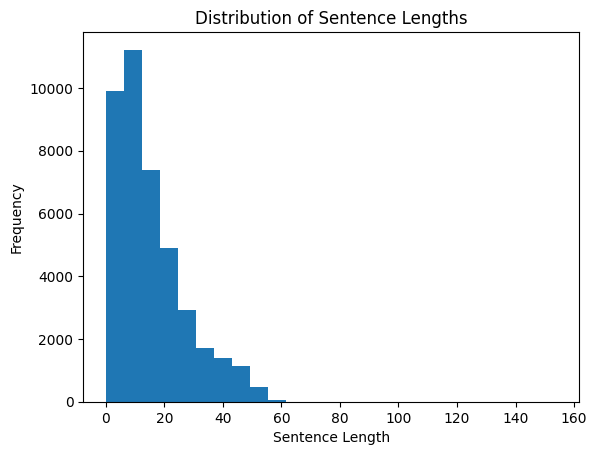

Max length: 154


In [146]:
lengths = [len(text) for text in X_train]
plt.hist(lengths, bins=25)
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths")
plt.show()

print(f'Max length: {max(lengths)}')

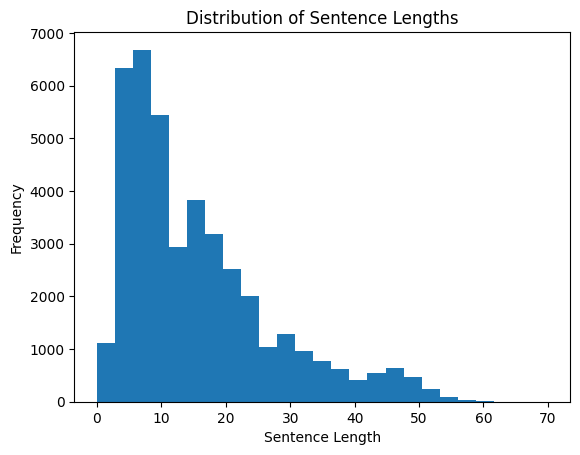

In [147]:
plt.hist(lengths, bins=25, range=(0, 70))
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths")
plt.show()


After these plots and having seen that the max length is 154, we can see that most of the sentences are in the 0-25 range, so that's the maximum length I will take, that means that longer ones will get truncated and shorted ones will be padded.

In [148]:
def pad_and_truncate(sentence, word_to_id, max_length):
  if len(sentence) < max_length:
    padding_length = max_length - len(sentence)
    sentence += [word_to_id["<PAD>"]] * padding_length 
  else:
    sentence = sentence[:max_length]  

  return sentence

# Example usage:
max_length = 25
print("Before\n")
print(X_train[0])
X_train = X_train.apply(lambda x: pad_and_truncate(x, word_to_id, max_length))
X_test =  X_test.apply(lambda x: pad_and_truncate(x, word_to_id, max_length))
print("After\n")
print(X_train[0])

Before

[10631, 8492, 349, 2522, 6191, 9573, 17826, 5979, 10650, 9167, 14990, 13689, 12438]
After

[10631, 8492, 349, 2522, 6191, 9573, 17826, 5979, 10650, 9167, 14990, 13689, 12438, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Now we can finally create the model. I'm going to use `TensorFlow` for this. I will not use the embedding layers since the fun here is that I did my own embedding to see how well this can work.

In [157]:
model = tf.keras.Sequential([
    # Input layer max_length, thats why the padding and truncate
    layers.Input(shape=(max_length,)),
    # Hidden layer
    layers.Dense(64, activation='relu'),
    # Dropout deactivates some neurons each time to avoid overfitting
    layers.Dropout(0.2),
    # Second hidden layer
    layers.Dense(32, activation='relu'), 
    # Binary
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert X_train and X_test to NumPy arrays for TensorFlow compatibility
X_train_tensor = tf.convert_to_tensor(X_train.tolist())
X_test_tensor = tf.convert_to_tensor(X_test.tolist())

# Train the model
history = model.fit(X_train_tensor, y_train, epochs=50, validation_data=(X_test_tensor, y_test), batch_size=32)

# Print the model summary
model.summary()

Epoch 1/50
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5550 - loss: 223.0415 - val_accuracy: 0.5689 - val_loss: 0.6939
Epoch 2/50
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5694 - loss: 1.1150 - val_accuracy: 0.5694 - val_loss: 0.6838
Epoch 3/50
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5701 - loss: 0.7748 - val_accuracy: 0.5695 - val_loss: 0.6834
Epoch 4/50
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5731 - loss: 0.7548 - val_accuracy: 0.5695 - val_loss: 0.6835
Epoch 5/50
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5707 - loss: 0.7239 - val_accuracy: 0.5695 - val_loss: 0.6835
Epoch 6/50
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5705 - loss: 0.7054 - val_accuracy: 0.5695 - val_loss: 0.6835
Epoch 7/50
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5728 - loss: 0.7015 - val_accuracy: 0.5707 - val_loss: 0.6833
Epoch 8/50
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5755 - loss: 0.7049 

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,333 (44.27 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,556 (29.52 KB)

In [158]:
sentences = [
    "I think the spotify application is super bad, I don't like it at all, there is no worse application",
    "Spotify is my favourite app, I can't live without it!",
]

sentences = [clean_text(sentence) for sentence in sentences]
sentences = [tokenize_text(sentence) for sentence in sentences]
sentences = [remove_stopwords(sentence) for sentence in sentences]
sentences = [basic_stemmer(sentence) for sentence in sentences]
sentences = [sentence_to_ids(sentence, word_to_id) for sentence in sentences]
sentences = [pad_and_truncate(sentence, word_to_id, max_length) for sentence in sentences]

sentences_tensor = tf.convert_to_tensor(sentences)

print(model.predict(sentences_tensor))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[0.43070778]
 [0.43070778]]
